# Group 5 - Final Report
### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins

In [104]:
#Libraries Imported
import pandas as pd
import numpy as np
from numpy import mean, where
from datetime import date
import geopy.distance
from math import sin, cos, sqrt, atan2, radians, log
import time
from collections import Counter
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix,classification_report,make_scorer, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### EDA - Data Loading

In [4]:
df_test=pd.read_csv('fraudTest.csv')
df_train=pd.read_csv('fraudTrain.csv')  

fraud_df= df_test.append(df_train)
fraud_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


### EDA - Data Preprocessing

In [5]:
# Checking for missing values
fraud_df.isnull().any().sum()

0

In [6]:
fraud_df.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

In [7]:
fraud_df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

### EDA - Column Exploration

Text(0, 0.5, 'Volume')

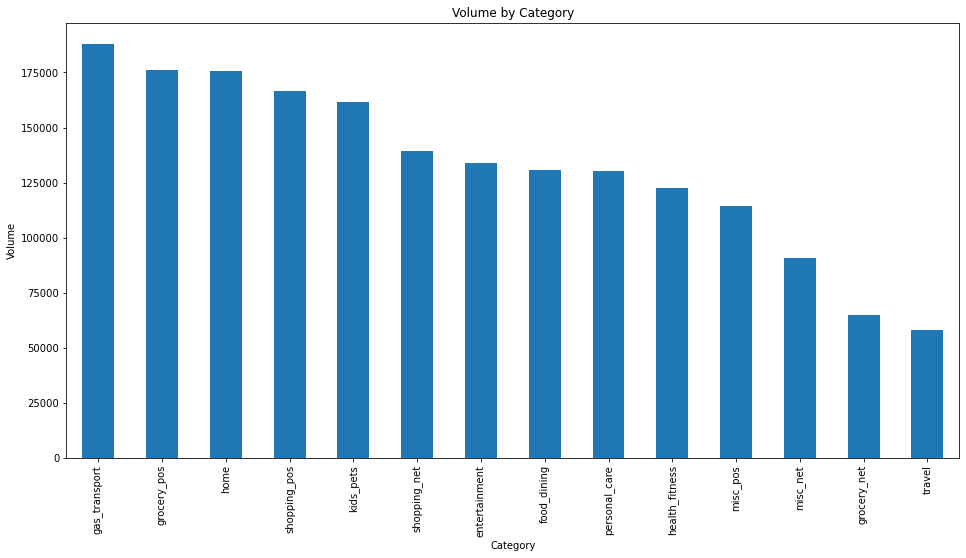

In [8]:
plt = pd.value_counts(fraud_df['category']).plot.bar(figsize=(16, 8), title="Volume by Category")
plt.set_xlabel('Category')
plt.set_ylabel('Volume')

Text(0, 0.5, 'Volume')

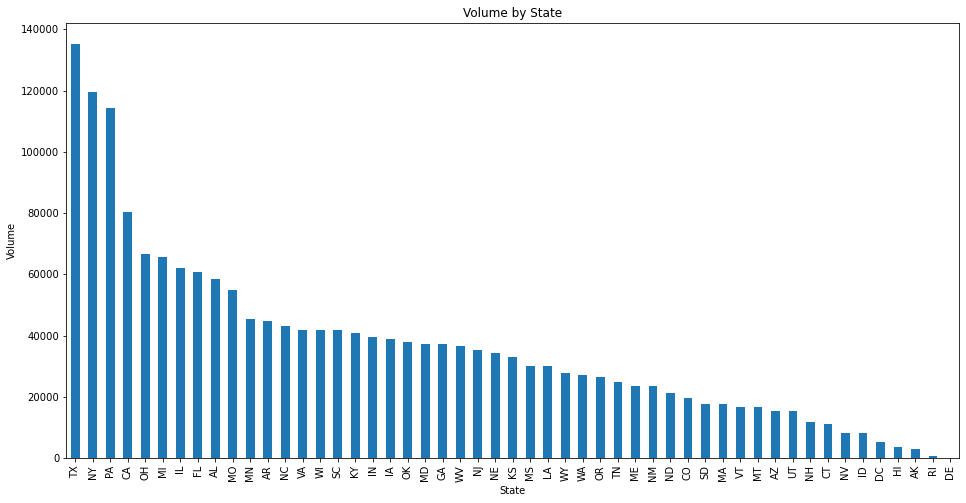

In [9]:
plt = pd.value_counts(fraud_df['state']).plot.bar(figsize=(16, 8), title="Volume by State")
plt.set_xlabel('State')
plt.set_ylabel('Volume')

Text(0, 0.5, 'Volume')

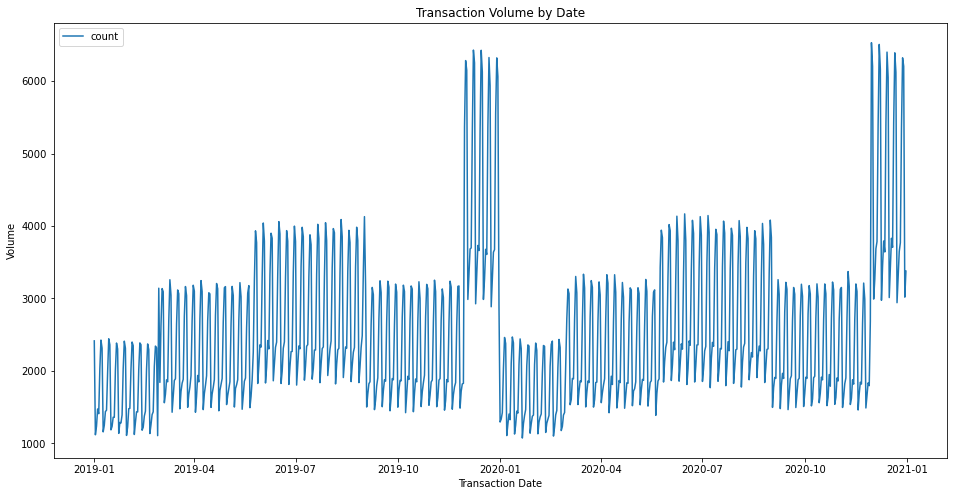

In [10]:
fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

fraud_df['date_of_birth'] =  pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')
fraud_df['year_of_birth'] = fraud_df['date_of_birth'].dt.year
fraud_df['date_of_birth'] = fraud_df['date_of_birth'].dt.date

fraud_df['txn_date'] = fraud_df['txn_datetime'].dt.date
txn_count_by_date = fraud_df['txn_date'].value_counts().sort_index().reset_index()
txn_count_by_date.columns = ['txn_date','count']
plt = txn_count_by_date.plot.line(x='txn_date', y='count', figsize=(16, 8), title="Transaction Volume by Date")
plt.set_xlabel('Transaction Date')
plt.set_ylabel('Volume')

Text(0, 0.5, 'Count')

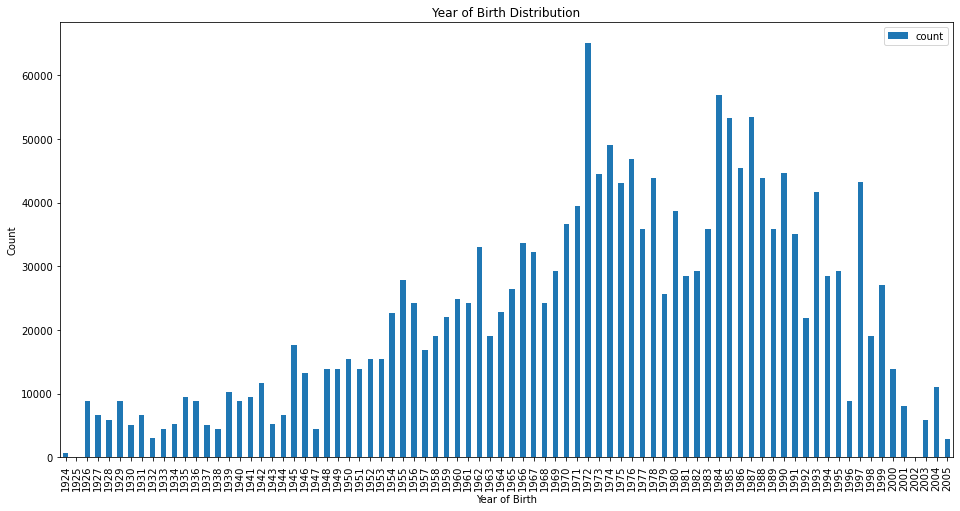

In [11]:
dob_counts = fraud_df['year_of_birth'].value_counts().sort_index().reset_index()
dob_counts.columns = ['year_of_birth','count']

plt = dob_counts.plot.bar(x='year_of_birth', y='count', figsize=(16, 8), title="Year of Birth Distribution")
plt.set_xlabel('Year of Birth')
plt.set_ylabel('Count')

In [12]:
# Number of merchants in the dataset

print(f"Number of merchants: {fraud_df['merchant'].nunique()}")

# Number of cards in the dataset

print(f"Number of cards: {fraud_df['cc_num'].nunique()}")

# Number of cards in the dataset

print(f"Number of unique users: {fraud_df.groupby(['first', 'last', 'gender', 'street', 'city']).ngroups}")


Number of merchants: 693
Number of cards: 999
Number of unique users: 999


Text(0, 0.5, 'Volume')

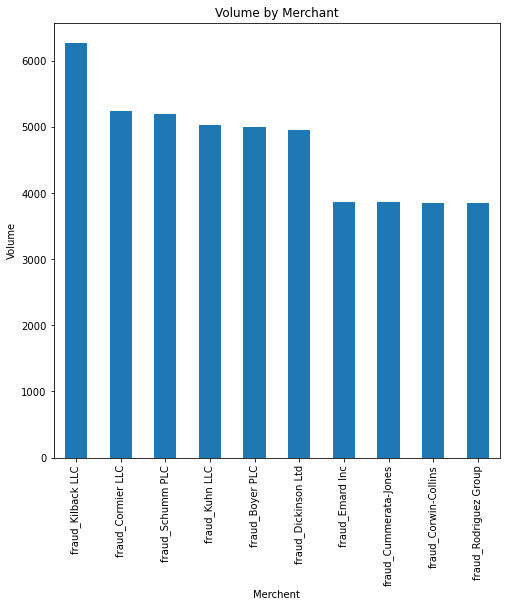

In [13]:
plt = pd.value_counts(fraud_df['merchant']).nlargest(10).plot.bar(figsize=(8, 8), title="Volume by Merchant")
plt.set_xlabel('Merchent')
plt.set_ylabel('Volume')

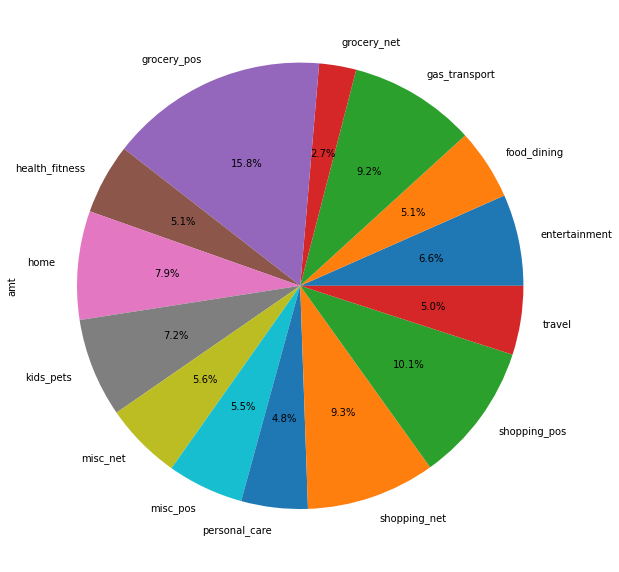

In [14]:
category_amt = fraud_df.groupby("category")["amt"].sum()
category_amt.plot.pie(autopct="%.1f%%", figsize=(10, 12))

### EDA - Special Features Engineering

#### Calculating Age from Date of Birth Column 

In [15]:
#Calculate Age
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]

#### Calculating Distance between card holder and merchant

In [16]:
def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]

#### Separating Time Buckets from Datetime Column

In [17]:
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

#### Removing Columns used to derive new features

In [18]:
fraud_df.drop([
    'Unnamed: 0',
    'trans_num',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'dob',
    'trans_date_trans_time',
    'lat',
    'long',
    'merch_lat',
    'merch_long'
], axis=1, errors='ignore', inplace=True)

cols = list(fraud_df.columns)
cols.insert(0, cols.pop(cols.index("txn_datetime")))
cols.append(cols.pop(cols.index('is_fraud')))
fraud_df = fraud_df[cols]

fraud_df.head()

,txn_datetime,cc_num,merchant,category,amt,gender,city_pop,job,date_of_birth,year_of_birth,txn_date,age,distance,hour,day,month,year,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,M,333497,Mechanical engineer,1968-03-19,1968,2020-06-21,52,24.613746,12,21,6,2020,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,F,302,"Sales professional, IT",1990-01-17,1990,2020-06-21,30,104.834043,12,21,6,2020,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,34496,"Librarian, public",1970-10-21,1970,2020-06-21,50,59.204796,12,21,6,2020,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,M,54767,Set designer,1987-07-25,1987,2020-06-21,33,27.615117,12,21,6,2020,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,M,1126,Furniture designer,1955-07-06,1955,2020-06-21,65,104.423175,12,21,6,2020,0


### EDA - Outlier Detection

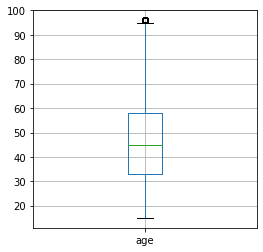

In [19]:
fraud_df.boxplot(column='age', figsize=(4, 4))

Transaction Amount:
count    1.852394e+06
mean     7.006357e+01
std      1.592540e+02
min      1.000000e+00
25%      9.640000e+00
50%      4.745000e+01
75%      8.310000e+01
max      2.894890e+04
Name: amt, dtype: float64


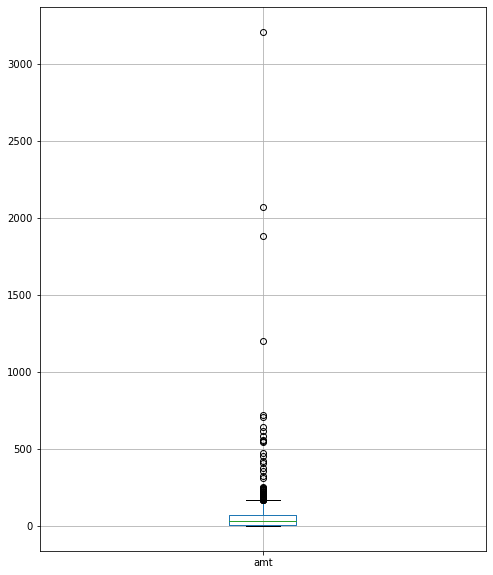

In [20]:
stats = fraud_df['amt'].describe()
print("Transaction Amount:")
print(stats)
fraud_df.head(1000).boxplot(column='amt', figsize=(8, 10))

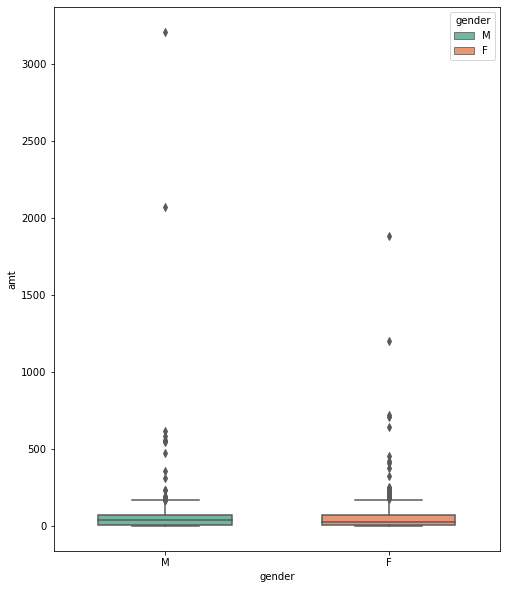

In [24]:
gender_amt = pd.DataFrame(fraud_df.head(1000), columns = ['amt', 'gender'])
plt.figure(figsize=(8,10))
sns.boxplot(y='amt', x='gender', data=gender_amt, hue='gender', dodge=False, width = 0.6, palette= 'Set2')

### EDA - Imbalance Identification

In [31]:
fraud_counts = fraud_df['is_fraud'].value_counts().sort_index().reset_index()
fraud_counts.columns = ['is_fraud','count']

# print(fraud_counts)

no_fraud_count = fraud_counts.loc[fraud_counts['is_fraud'] == 0].iloc[0]['count']
fraud_count = fraud_counts.loc[fraud_counts['is_fraud'] == 1].iloc[0]['count']

percent_with_fraud = "{:.2f}".format(((fraud_count / no_fraud_count) * 100))

print(f"No Fraud Count: {no_fraud_count}")
print(f"Fraud Count: {fraud_count}")
print(f"Fraud Percentage: {percent_with_fraud}%")

No Fraud Count: 1842743
Fraud Count: 9651
Fraud Percentage: 0.52%


### Data Encoding - One Hot Encoder

In [32]:
cat_col = ['category','gender']
fraud_df['Target'] = fraud_df['amt']
#This one hot encodes the categorical columns and create a new variable to hold the nex column headers
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cat_col_onehotencode = []
fraud_df[cat_col_onehotencode].head()

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [33]:
fraud_df.to_csv('df_cat.csv', index=False)

In [34]:
df=pd.read_csv('df_cat.csv')
df.head(10)

,txn_datetime,cc_num,merchant,category,amt,gender,city_pop,job,date_of_birth,year_of_birth,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,M,333497,Mechanical engineer,1968-03-19,1968,...,0,0,0,0,0,1,0,0,0,1
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,F,302,"Sales professional, IT",1990-01-17,1990,...,0,0,0,0,0,1,0,0,0,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,34496,"Librarian, public",1970-10-21,1970,...,1,0,0,0,0,0,0,0,0,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,M,54767,Set designer,1987-07-25,1987,...,0,0,0,0,1,0,0,0,0,1
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,M,1126,Furniture designer,1955-07-06,1955,...,0,0,0,0,0,0,0,0,1,1
5,2020-06-21 12:15:37,30407675418785,fraud_Daugherty LLC,kids_pets,19.55,F,520,Psychotherapist,1991-10-13,1991,...,0,0,1,0,0,0,0,0,0,0
6,2020-06-21 12:15:44,213180742685905,fraud_Romaguera Ltd,health_fitness,133.93,F,1139,"Therapist, occupational",1951-01-15,1951,...,1,0,0,0,0,0,0,0,0,0
7,2020-06-21 12:15:50,3589289942931264,fraud_Reichel LLC,personal_care,10.37,F,343,"Development worker, international aid",1972-03-05,1972,...,0,0,0,0,0,1,0,0,0,0
8,2020-06-21 12:16:10,3596357274378601,"fraud_Goyette, Howell and Collier",shopping_pos,4.37,M,3688,Advice worker,1973-05-27,1973,...,0,0,0,0,0,0,0,1,0,1
9,2020-06-21 12:16:11,3546897637165774,fraud_Kilback Group,food_dining,66.54,F,263,Barrister,1956-05-30,1956,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df.drop([
    'cc_num',
    'merchant',
    'category',
    'last',
    'job',
    'date_of_birth',
    'year_of_birth',
    'gender',
    'txn_datetime',
    'txn_date',
    'Target'
], axis=1, errors='ignore', inplace=True)
df.head()

,amt,city_pop,age,distance,hour,day,month,year,is_fraud,category_food_dining,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2.86,333497,52,24.613746,12,21,6,2020,0,0,...,0,0,0,0,0,1,0,0,0,1
1,29.84,302,30,104.834043,12,21,6,2020,0,0,...,0,0,0,0,0,1,0,0,0,0
2,41.28,34496,50,59.204796,12,21,6,2020,0,0,...,1,0,0,0,0,0,0,0,0,0
3,60.05,54767,33,27.615117,12,21,6,2020,0,0,...,0,0,0,0,1,0,0,0,0,1
4,3.19,1126,65,104.423175,12,21,6,2020,0,0,...,0,0,0,0,0,0,0,0,1,1


In [36]:
df.nunique()

amt                          60616
city_pop                       891
age                             82
distance                   1852394
hour                            24
day                             31
month                           12
year                             2
is_fraud                         2
category_food_dining             2
category_gas_transport           2
category_grocery_net             2
category_grocery_pos             2
category_health_fitness          2
category_home                    2
category_kids_pets               2
category_misc_net                2
category_misc_pos                2
category_personal_care           2
category_shopping_net            2
category_shopping_pos            2
category_travel                  2
gender_M                         2
dtype: int64

In [37]:
#df.sum

In [38]:
#Breaking it into two parts, separate the target variable from the other columns
X=df.drop('is_fraud',axis=1).copy()
X.head()

,amt,city_pop,age,distance,hour,day,month,year,category_food_dining,category_gas_transport,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2.86,333497,52,24.613746,12,21,6,2020,0,0,...,0,0,0,0,0,1,0,0,0,1
1,29.84,302,30,104.834043,12,21,6,2020,0,0,...,0,0,0,0,0,1,0,0,0,0
2,41.28,34496,50,59.204796,12,21,6,2020,0,0,...,1,0,0,0,0,0,0,0,0,0
3,60.05,54767,33,27.615117,12,21,6,2020,0,0,...,0,0,0,0,1,0,0,0,0,1
4,3.19,1126,65,104.423175,12,21,6,2020,0,0,...,0,0,0,0,0,0,0,0,1,1


In [39]:
y=df['is_fraud'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3 , stratify=y)

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1296675, 22)
(1296675,)
(555719, 22)
(555719,)


### Resampling

Counter({0: 99000, 1: 1000})
Counter({0: 33000, 1: 19800})


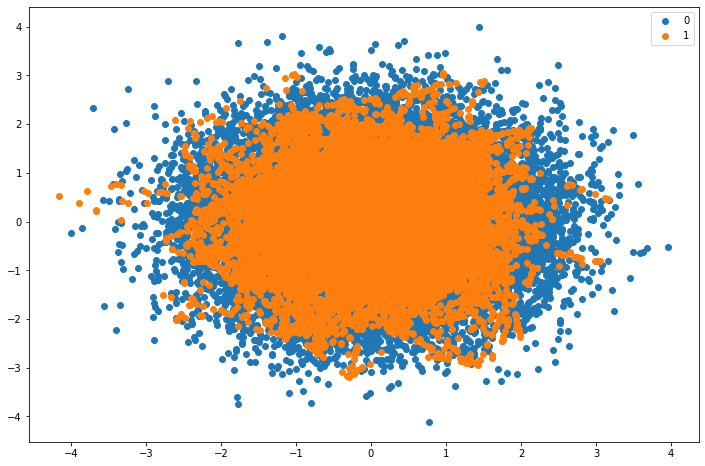

In [158]:
# Oversample with SMOTE and random undersample for imbalanced dataset
# Define dataset
X_train, y_train = make_classification(n_samples=100000, n_features=22, n_redundant=2, n_clusters_per_class=2, 
                           weights=[0.99], flip_y=0, random_state=1)

# Summarize class distribution
counter = Counter(y_train)
print(counter)

# Define pipeline
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

# Summarize the new class distribution
counter = Counter(y_train)
print(counter)


# Scatter plot of examples by class label
plt.figure(figsize=(12, 8))
for label, _ in counter.items():
    row_ix = where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))

plt.legend()
plt.show()

In [43]:
print('After resampling, the shape of X_train: {}'.format(X_train.shape)) 
print('After resampling, the shape of y_train: {} \n'.format(y_train.shape)) 

print("After resampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("After resampling, counts of label '0': {}".format(sum(y_train == 0))) 

After resampling, the shape of X_train: (52800, 22)
After resampling, the shape of y_train: (52800,) 

After resampling, counts of label '1': 19800
After resampling, counts of label '0': 33000


## Tree-based Models

### Decision Tree

In [77]:
#Create a Baseline Model
dt=DecisionTreeClassifier(random_state = 12)

dt.fit(X_train, y_train)
dt.score(X_train, y_train)

# Predict Output
y_preds = dt.predict(X_test)

print('Baseline Decision Tree')

# Accuracy Score on test dataset
dt_acc_test = metrics.accuracy_score(y_test, y_preds)
print('\nAccuracy: %.2f%%' % (dt_acc_test * 100.0))

# Calculate roc auc
dt_probs_test = dt.predict_proba(X_test)[:, 1]
dt_roc_value_test = roc_auc_score(y_test, dt_probs_test)
print('\nROC AUC: ', round(dt_roc_value_test,2))

Baseline Decision Tree

Accuracy: 63.66%

ROC AUC:  0.46


In [45]:
#Create Optimized Model

ccp_alpha=[0.0,0.2]
class_weight=[None]
criterion=['gini','entropy']
max_depth=[3,4,5]
max_features=["auto", "sqrt", "log2","none"]
max_leaf_nodes=[3,4,5]
min_impurity_decrease=[0.0]
min_impurity_split=[None]
min_samples_leaf=[1,2,5,10]
min_samples_split=[1,2,5,10]
min_weight_fraction_leaf=[0.0,0.1,0.25]
random_state=[24]
splitter=['best','random']

#param_grid

param_grid_dt = {'ccp_alpha': ccp_alpha,
 'class_weight': class_weight,
 'criterion': criterion,
 'max_depth': max_depth,
 'max_features': max_features,
 'max_leaf_nodes': max_leaf_nodes,
 'min_impurity_decrease': min_impurity_decrease,
 'min_impurity_split': min_impurity_split,
 'min_samples_leaf': min_samples_leaf,
 'min_samples_split': min_samples_split,
 'min_weight_fraction_leaf': min_weight_fraction_leaf,
 'random_state': random_state,
 'splitter': splitter}

print(param_grid_dt)

{'ccp_alpha': [0.0, 0.1, 0.2, 0.5], 'class_weight': [None], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 10], 'max_features': ['auto', 'sqrt', 'log2', 'none'], 'max_leaf_nodes': [3, 4, 5, 10], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [1, 2, 5, 10], 'min_weight_fraction_leaf': [0.0, 0.1, 0.25], 'random_state': [24], 'splitter': ['best', 'random']}


In [46]:
# create the cross-validation by grid method
auc_scoring = make_scorer(roc_auc_score)

dt_grid = GridSearchCV(estimator = dt, param_grid = param_grid_dt, 
                            cv = 5, scoring=auc_scoring,verbose = 1, n_jobs = -1, 
                            error_score=0)

# fit the random search model
t1 = time.time()
dt_grid.fit(X_train, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',dt_grid.best_params_)

Fitting 5 folds for each of 49152 candidates, totalling 245760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2960 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 4760 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 6992 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 12192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 18192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 24992 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 32592 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 40992 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 50192 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 60192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 70992 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 82592 ta

Elapsed Time: 1853.7536578178406
Best Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 3, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1, 'random_state': 24, 'splitter': 'best'}


In [78]:
print('Optimized Decision Tree')

y_preds_grid = dt_grid.best_estimator_.predict_proba(X_test)[:,1]

dt_opt_acc = accuracy_score(y_test, y_preds_grid.round())
print('\nAccuracy: %.2f%%' % (dt_opt_acc * 100.0))

dt_opt_auc = roc_auc_score(y_test, y_preds_grid)
print('\nROC AUC: ', round(dt_opt_auc,2))

Optimized Decision Tree

Accuracy: 90.23%

ROC AUC:  0.57


### Confusion Matrix

Confusion matrix : 
 [[500766  52058]
 [  2225    670]]
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    552824
           1       0.01      0.23      0.02      2895

    accuracy                           0.90    555719
   macro avg       0.50      0.57      0.49    555719
weighted avg       0.99      0.90      0.94    555719



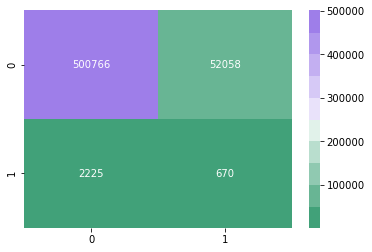

In [102]:
# confusion matrix
DTmatrix = confusion_matrix(y_test, y_preds_grid.round())
print('Confusion matrix : \n',DTmatrix)

# classification report for precision, recall f1-score and accuracy
DTmatrix1 = classification_report(y_test,y_preds_grid.round())
print('Classification report : \n',DTmatrix1)

cmap =  sns.diverging_palette(150, 275, s=80, l=60, n=10)
sns.heatmap(DTmatrix, annot=True,fmt='.0f',cmap=cmap)
plt.show()

### Feature Importances

In [91]:
# Extract feature importances
DT_Feature_Imp = pd.DataFrame({'features': list(X),
                   'importance': dt.feature_importances_}).\
                    sort_values('importance', ascending = False)
DT_Feature_Imp = DT_Feature_Imp.head(10)
DT_Feature_Imp

,features,importance
11,category_grocery_pos,0.794296
15,category_misc_net,0.060506
17,category_personal_care,0.024574
6,month,0.008582
1,city_pop,0.007731
21,gender_M,0.007692
5,day,0.007543
14,category_kids_pets,0.007280
0,amt,0.007257
20,category_travel,0.007095


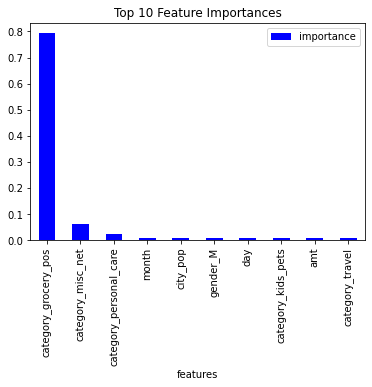

In [92]:
DT_Feature_Imp.plot(x ='features', y='importance', kind = 'bar', color ='blue', title='Top 10 Feature Importances')
plt.show()

### Random Forest

In [81]:
#Create a Baseline Model
rf=RandomForestClassifier(random_state = 12)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

print('Baseline Random Forest')

print('\nNumber of Trees used : ', rf.n_estimators)

rf_acc = accuracy_score(y_test,rf_preds)
print('\nAccuracy: %.2f%%' % (rf_acc * 100.0))

rf_base_auc = roc_auc_score(y_test, rf_preds)
print('\nROC AUC: ', round(rf_base_auc,2))

Baseline Random Forest

Number of Trees used :  100

Accuracy: 99.48%

ROC AUC:  0.5


In [82]:
#Create Optimized Model

bootstrap=[True,False]
ccp_alpha=[0.0,0.2]
class_weight=[None]
criterion=['gini','entropy']
max_depth=[3,4,5]
max_features=["auto", "sqrt", "log2","none"]
max_leaf_nodes=[None]
max_samples=[0,.5,1]
min_impurity_decrease=[0.0]
min_impurity_split=[None]
min_samples_leaf=[1,2,10]
min_samples_split=[1,2,10]
n_estimators=[10,100,250]
n_jobs=[-1]
oob_score=[True,False]
random_state=[12]
verbose=[1]
warm_start=[True,False]

#param_grid

param_grid_rf = {'bootstrap': bootstrap,
 'ccp_alpha': ccp_alpha,
 'class_weight': class_weight,
 'criterion': criterion,
 'max_depth': max_depth,
 'max_features': max_features,
 'max_leaf_nodes': max_leaf_nodes,
 'max_samples': max_samples,
 'min_impurity_decrease': min_impurity_decrease,
 'min_impurity_split': min_impurity_split,
 'min_samples_leaf': min_samples_leaf,
 'min_samples_split': min_samples_split,
 'min_weight_fraction_leaf': min_weight_fraction_leaf,
 'n_estimators': n_estimators,
 'n_jobs': n_jobs,
 'oob_score': oob_score,
 'random_state': random_state,
 'verbose': verbose,
 'warm_start': warm_start}

print(param_grid_rf)

{'bootstrap': [True, False], 'ccp_alpha': [0.0, 0.2], 'class_weight': [None], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5], 'max_features': ['auto', 'sqrt', 'log2', 'none'], 'max_leaf_nodes': [None], 'max_samples': [0, 0.5, 1], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'min_samples_leaf': [1, 2, 10], 'min_samples_split': [1, 2, 10], 'min_weight_fraction_leaf': [0.0, 0.1, 0.25], 'n_estimators': [10, 100, 250], 'n_jobs': [-1], 'oob_score': [True, False], 'random_state': [12], 'verbose': [1], 'warm_start': [True, False]}


In [83]:
#Random grid search used for time constraints:
rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, 
                            n_iter = 1000, cv = 5, scoring=auc_scoring,verbose = 1, n_jobs = -1,
                            error_score=0, random_state=12)
        

# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_rand.fit(X_train, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',rf_rand.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1854 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2506 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 3488 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 4354 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 23.8min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.0s finished


Elapsed Time: 1435.5347800254822
Best Parameters: {'warm_start': False, 'verbose': 1, 'random_state': 12, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 250, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_samples': 0.5, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'class_weight': None, 'ccp_alpha': 0.0, 'bootstrap': True}


In [93]:
print('Optimized Random Forest')
y_preds_rand = rf_rand.best_estimator_.predict_proba(X_test)[:,1]

rf_opt_acc = accuracy_score(y_test,y_preds_rand.round())
print('\nAccuracy: %.2f%%' % (rf_opt_acc * 100.0))

rf_opt_auc = roc_auc_score(y_test, y_preds_rand.round())
print('\nROC AUC: ', round(rf_opt_auc,2))

Optimized Random Forest


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s



Accuracy: 90.23%

ROC AUC:  0.57


[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    1.2s finished


### Confusion Matrix

Confusion matrix : 
 [[500766  52058]
 [  2225    670]]
Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    552824
           1       0.01      0.23      0.02      2895

    accuracy                           0.90    555719
   macro avg       0.50      0.57      0.49    555719
weighted avg       0.99      0.90      0.94    555719



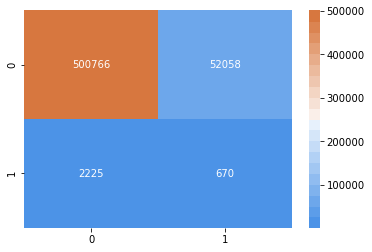

In [101]:
# confusion matrix
RFmatrix = confusion_matrix(y_test, y_preds_rand.round())
print('Confusion matrix : \n',RFmatrix)

# classification report for precision, recall f1-score and accuracy
RFmatrix1 = classification_report(y_test,y_preds_rand.round())
print('Classification report : \n',RFmatrix1)

cmap =  sns.diverging_palette(250, 30, s=80, l=60, n=20)
sns.heatmap(RFmatrix, annot=True,fmt='.0f', cmap=cmap)
plt.show()

### Feature Importances

In [89]:
# Extract feature importances
RF_Feature_Imp = pd.DataFrame({'features': list(X),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
RF_Feature_Imp = RF_Feature_Imp.head(10)
RF_Feature_Imp

,features,importance
11,category_grocery_pos,0.543077
9,category_gas_transport,0.195319
15,category_misc_net,0.062333
17,category_personal_care,0.048829
18,category_shopping_net,0.010499
14,category_kids_pets,0.010089
5,day,0.009976
2,age,0.009289
20,category_travel,0.008875
7,year,0.008441


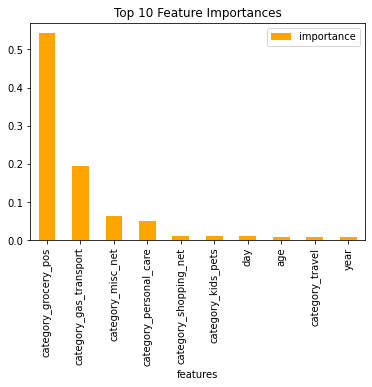

In [90]:
RF_Feature_Imp.plot(x ='features', y='importance', kind = 'bar', color ='orange', title='Top 10 Feature Importances')
plt.show()

## XgBoost Model

In [115]:
count = len(df)
train2 = df[:count]
test2 = df[count:]
X2 = train2.drop(['is_fraud'], axis=1)
y2 = train2['is_fraud'].astype('int')
test2 = test2.drop(['is_fraud'], axis=1)
X_train2,X_test2, y_train2,y_test2 = train_test_split(X2, y2, test_size=0.3,random_state=123)

print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1296675, 22)
(1296675,)
(555719, 22)
(555719,)


In [116]:
XGB = xgb.XGBClassifier(n_estimators = 50, objective='binary:logistic', booster='gbtree',
                        colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10)

XGB.fit(X_train2,y_train2)

# Predict Output
XGB_pred = XGB.predict(X_test2)

# Accuracy Score on test dataset
XGB_accuracy = accuracy_score(y_test2,XGB_pred)
print("Accuracy: %.2f%%" % (XGB_accuracy * 100.0))

XGB_probs = XGB.predict_proba(X_test2)[:, 1]

# Calculate roc auc
XGB_roc_value = roc_auc_score(y_test2, XGB_probs)
print('\nROC AUC : ', round(XGB_roc_value,2))

Accuracy: 99.54%

ROC AUC :  0.98


### Confusion Matrix

Confusion matrix : 
 [[500766  52058]
 [  2225    670]]
Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       1.00      0.14      0.24      2938

    accuracy                           1.00    555719
   macro avg       1.00      0.57      0.62    555719
weighted avg       1.00      1.00      0.99    555719



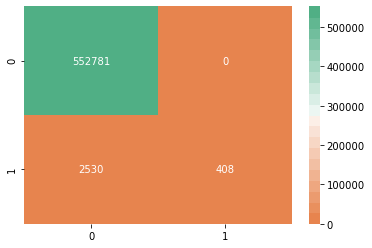

In [148]:
# confusion matrix
XGBmatrix = confusion_matrix(y_test2, XGB_pred)
print('Confusion matrix : \n',RFmatrix)

# classification report for precision, recall f1-score and accuracy
XGBmatrix1 = classification_report(y_test2,XGB_pred)
print('Classification report : \n',XGBmatrix1)

cmap =  sns.diverging_palette(30, 150, s=75, l=65, n=20)
sns.heatmap(XGBmatrix, annot=True,fmt='.0f', cmap=cmap)
plt.show()

### Feature Importances

In [153]:
# Extract feature importances
XGB_Feature_Imp = pd.DataFrame({'features': list(X),
                   'importance': XGB.feature_importances_}).\
                    sort_values('importance', ascending = False)
XGB_Feature_Imp = XGB_Feature_Imp.head(10)
XGB_Feature_Imp

,features,importance
9,category_gas_transport,0.618332
11,category_grocery_pos,0.114567
0,amt,0.067872
4,hour,0.061888
16,category_misc_pos,0.029923
18,category_shopping_net,0.023106
15,category_misc_net,0.016268
19,category_shopping_pos,0.015123
10,category_grocery_net,0.008890
2,age,0.008029


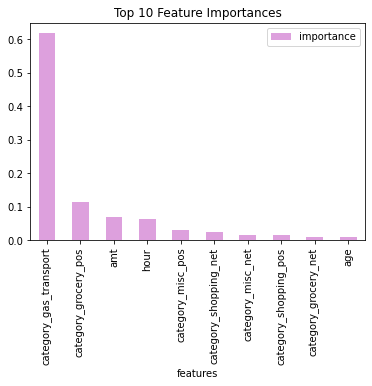

In [155]:
XGB_Feature_Imp.plot(x ='features', y='importance', kind = 'bar', color ='plum', title='Top 10 Feature Importances')
plt.show()